# 1. Imports

In [48]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import math

# 2. Loading the dataset

In [49]:
df = pd.read_csv("../../data/processed/COEN498-691_HAR_dataset.csv", header=0, sep = ",")
df.head(10)

,timestamp,activity_id,participant_id,ax,ay,az
0,1.760380e+09,sitting,ZM,-0.001,0.849,0.484333
1,1.760380e+09,sitting,ZM,-0.008,0.850,0.483000
2,1.760380e+09,sitting,ZM,0.006,0.852,0.480000
3,1.760380e+09,sitting,ZM,0.001,0.851,0.477000
4,1.760380e+09,sitting,ZM,-0.002,0.853,0.481000
5,1.760380e+09,sitting,ZM,0.008,0.841,0.479000
6,1.760380e+09,sitting,ZM,-0.005,0.851,0.484000
7,1.760380e+09,sitting,ZM,-0.002,0.857,0.481000
8,1.760380e+09,sitting,ZM,0.002,0.847,0.478000
9,1.760380e+09,sitting,ZM,-0.004,0.853,0.467000


In [50]:
participant_ids = np.unique(df['participant_id'])
print("Participant IDs:", participant_ids)

Participant IDs: ['LL' 'VV' 'YL' 'YT' 'ZM']


In [51]:
activity_mapper = {
    'sitting': 1,
    'walking': 2,
    'running': 3,
    'lying': 4,
}

In [52]:
mapped_activities = df.activity_id.apply(lambda x: activity_mapper[x])
df.loc[:, 'activity_id'] = mapped_activities
activity_ids = np.unique(df['activity_id'])
print("Activity IDs:", activity_ids)
print(df.head(10))

Activity IDs: [1 2 3 4]
      timestamp activity_id participant_id     ax     ay        az
0  1.760380e+09           1             ZM -0.001  0.849  0.484333
1  1.760380e+09           1             ZM -0.008  0.850  0.483000
2  1.760380e+09           1             ZM  0.006  0.852  0.480000
3  1.760380e+09           1             ZM  0.001  0.851  0.477000
4  1.760380e+09           1             ZM -0.002  0.853  0.481000
5  1.760380e+09           1             ZM  0.008  0.841  0.479000
6  1.760380e+09           1             ZM -0.005  0.851  0.484000
7  1.760380e+09           1             ZM -0.002  0.857  0.481000
8  1.760380e+09           1             ZM  0.002  0.847  0.478000
9  1.760380e+09           1             ZM -0.004  0.853  0.467000


In [53]:
sensor_ids = ['ax', 'ay', 'az']

# 3. Trimming and normalization
**Removing transition noise at the end of activity recording**

In [54]:
sampling_frequency = 25  # Hz
trim_duration = 5  # seconds
trim_samples = int(trim_duration * sampling_frequency)

In [8]:
trimmed_dfs = []

for participant_id in participant_ids:
    participant_data = df[df['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id].copy()
        if len(activity_data) > trim_samples:
            trimmed_activity_data = activity_data.iloc[:-trim_samples]
            trimmed_dfs.append(trimmed_activity_data)
            
df_trimmed = pd.concat(trimmed_dfs, ignore_index=True)

In [ ]:
# Fix the sensor orientation for participant ZM
df_trimmed.loc[df_trimmed['participant_id'] == 'ZM', 'ay'] *= -1
df_trimmed.loc[df_trimmed['participant_id'] == 'ZM', 'ax'] *= -1

# 4. Filtering

## 4.4. Apply a band-pass filter (for dynamic activities)

In [202]:
sampling_frequency = 25  # Hz
lowcut = 0.5  # Hz
highcut = 10.0  # Hz

In [203]:
def butterworth_bandpass_filter(dataframe, lowcut, highcut, sampling_frequency, order=4):
    """
    Apply a Butterworth bandpass filter to the specified sensor columns (ax, ay, az) in the dataframe.
    """
    filtered_data = dataframe.copy()
    nyquist = 0.5 * sampling_frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    for sensor_id in sensor_ids:
        if sensor_id in filtered_data.columns:
            filtered_data[sensor_id] = signal.filtfilt(b, a, filtered_data[sensor_id])
    return filtered_data

In [204]:
# Apply the bandpass filter to each participant-activity pair
bp_filtered_dfs = []

for participant_id in participant_ids:
    participant_data = df_trimmed[df_trimmed['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id].copy()
        if not activity_data.empty:
            filtered_activity_data = butterworth_bandpass_filter(activity_data, lowcut, highcut, sampling_frequency)
            bp_filtered_dfs.append(filtered_activity_data)
bp_filtered_df = pd.concat(bp_filtered_dfs, ignore_index=True)

print(bp_filtered_df.head(10))

      timestamp activity_id participant_id        ax        ay        az
0  1.760381e+09           1             LL -0.000932 -0.000549 -0.001264
1  1.760381e+09           1             LL -0.024382 -0.004256 -0.001081
2  1.760381e+09           1             LL -0.009936 -0.003596  0.003583
3  1.760381e+09           1             LL -0.001908 -0.000451  0.001150
4  1.760381e+09           1             LL -0.009686 -0.001928  0.000943
5  1.760381e+09           1             LL -0.004036 -0.003297  0.008126
6  1.760381e+09           1             LL  0.000505 -0.000383  0.008834
7  1.760381e+09           1             LL -0.003319 -0.000204  0.006982
8  1.760381e+09           1             LL -0.003061 -0.002425  0.005147
9  1.760381e+09           1             LL -0.004698  0.000287 -0.002120


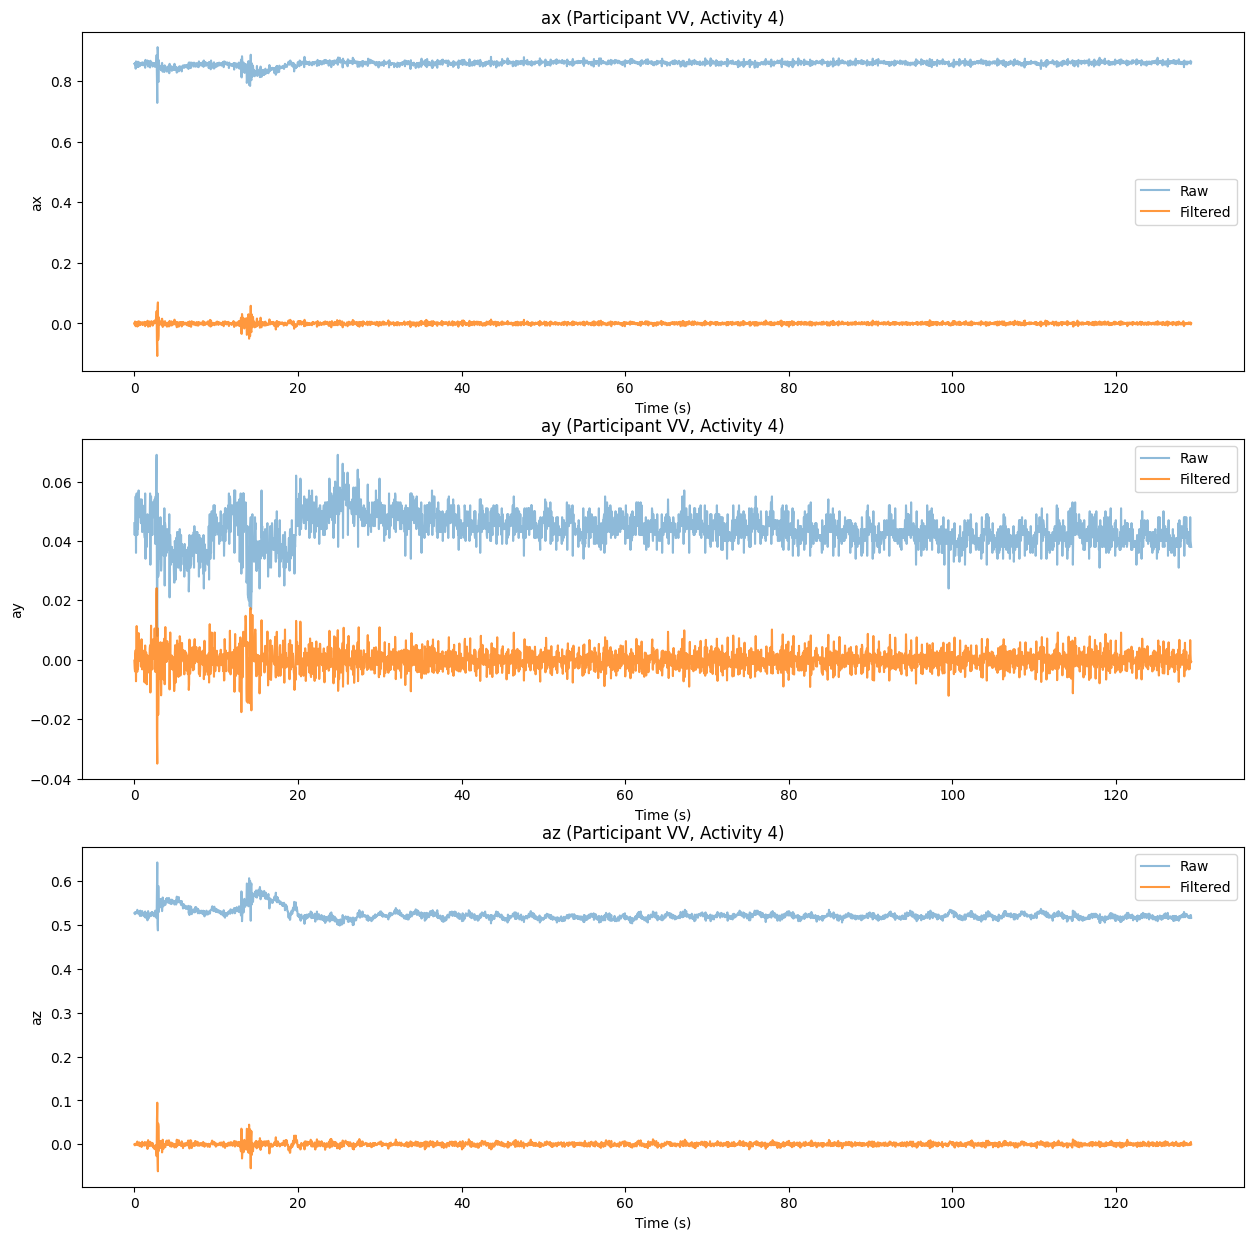

In [205]:
# Visualization of raw vs bandpass filtered data for a sample participant one activity
participant_to_plot = participant_ids[1] # 0: LL, 1: VV, 2: YL, 3: YT, 4: ZM
activity_to_plot = activity_ids[3] # 0: sitting, 1: walking, 2: running, 3: lying
original_data = df_trimmed[(df_trimmed['participant_id'] == participant_to_plot) & (df_trimmed['activity_id'] == activity_to_plot)]
filtered_data = bp_filtered_df[(bp_filtered_df['participant_id'] == participant_to_plot) & (bp_filtered_df['activity_id'] == activity_to_plot)]
time = original_data['timestamp'] - original_data['timestamp'].iloc[0]
plt.figure(figsize=(15, 15))
for i, sensor_id in enumerate(sensor_ids):
    plt.subplot(len(sensor_ids), 1, i + 1)
    plt.plot(time, original_data[sensor_id], label='Raw', alpha=0.5)
    plt.plot(time, filtered_data[sensor_id], label='Filtered', alpha=0.8)
    plt.title(f'{sensor_id} (Participant {participant_to_plot}, Activity {activity_to_plot})')
    plt.xlabel('Time (s)')
    plt.ylabel(sensor_id)
    plt.legend()


## 4.2 Apply a low-pass filter (for static activities)

In [206]:
lowcut = 0.1  # Hz

In [207]:
# Apply a low-pass filter to get gravity component
def butterworth_lowpass_filter(dataframe, cutoff, sampling_frequency, order=4):
    """
    Apply a Butterworth low-pass filter to the specified sensor columns (ax, ay, az) in the dataframe.
    """
    filtered_data = dataframe.copy()
    nyquist = 0.5 * sampling_frequency
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low')
    for sensor_id in sensor_ids:
        if sensor_id in filtered_data.columns:
            filtered_data[sensor_id] = signal.filtfilt(b, a, filtered_data[sensor_id])
    return filtered_data

In [208]:
# Apply the low-pass filter to each participant-activity pair
lp_filtered_dfs = []

for participant_id in participant_ids:
    participant_data = df_trimmed[df_trimmed['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id].copy()
        if not activity_data.empty:
            filtered_activity_data = butterworth_lowpass_filter(activity_data, lowcut, sampling_frequency)
            lp_filtered_dfs.append(filtered_activity_data)
lp_filtered_df = pd.concat(lp_filtered_dfs, ignore_index=True)

print(lp_filtered_df.head(10))

      timestamp activity_id participant_id        ax        ay        az
0  1.760381e+09           1             LL  0.064952 -1.023910  0.185476
1  1.760381e+09           1             LL  0.065224 -1.023911  0.185661
2  1.760381e+09           1             LL  0.065497 -1.023911  0.185848
3  1.760381e+09           1             LL  0.065773 -1.023910  0.186037
4  1.760381e+09           1             LL  0.066051 -1.023908  0.186228
5  1.760381e+09           1             LL  0.066331 -1.023906  0.186421
6  1.760381e+09           1             LL  0.066613 -1.023902  0.186616
7  1.760381e+09           1             LL  0.066898 -1.023898  0.186813
8  1.760381e+09           1             LL  0.067184 -1.023893  0.187011
9  1.760381e+09           1             LL  0.067472 -1.023887  0.187212


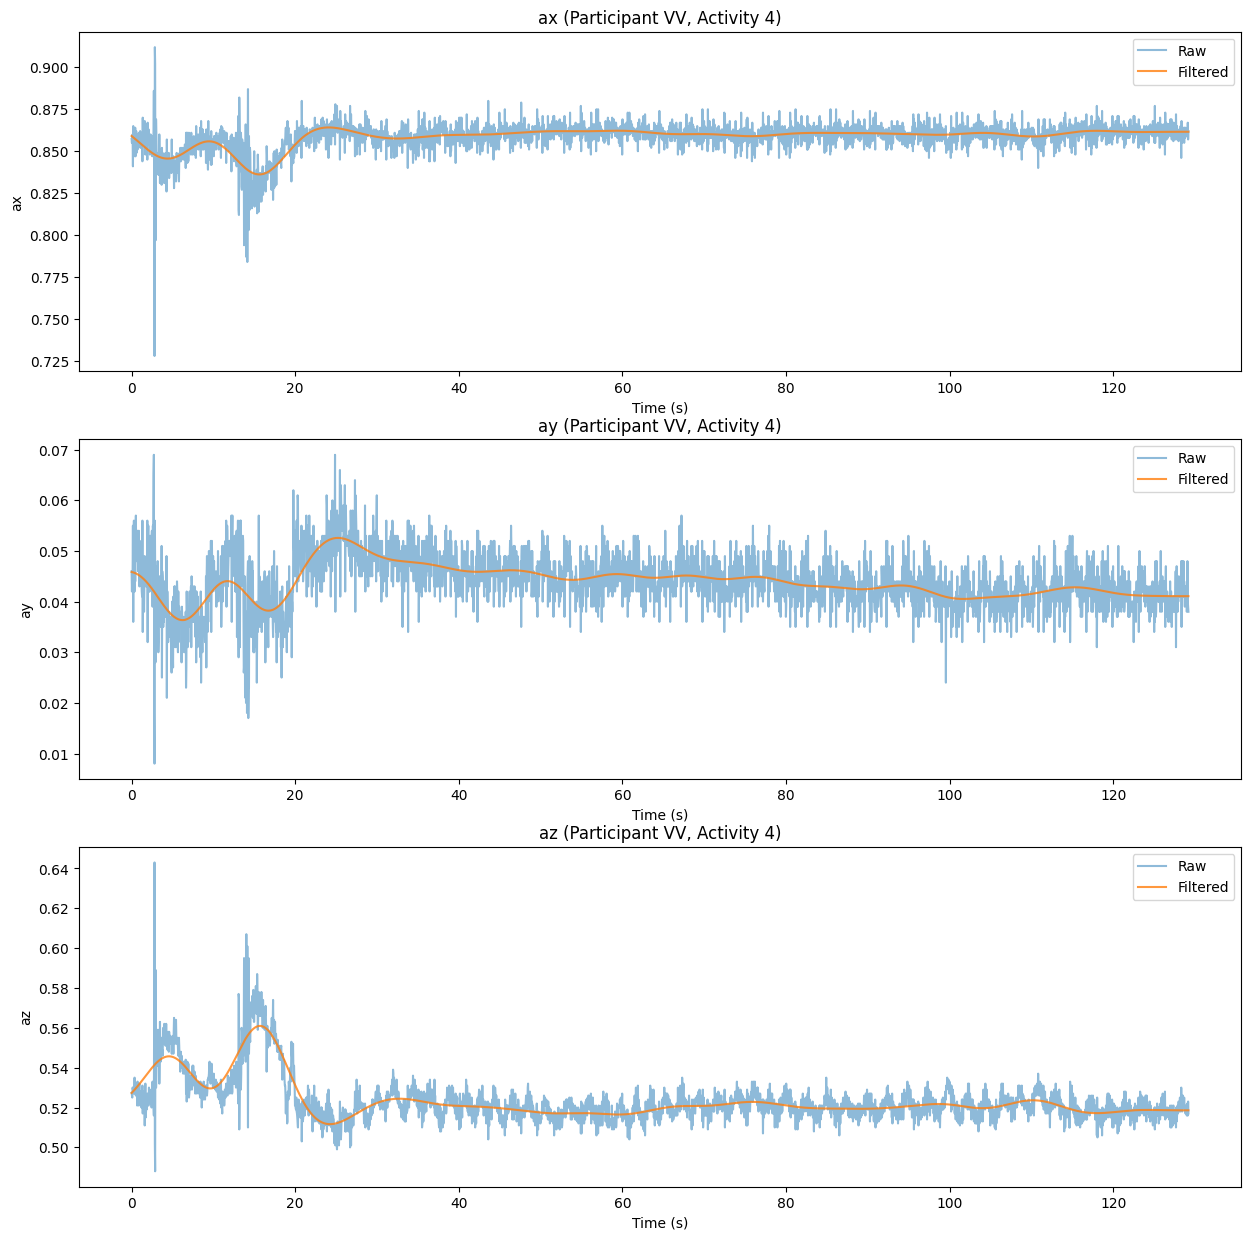

In [209]:
# Visualization of raw vs low-pass filtered data for a sample participant one activity
participant_to_plot = participant_ids[1] # 0: LL, 1: VV, 2: YL, 3: YT, 4: ZM
activity_to_plot = activity_ids[3] # 0: sitting, 1: walking, 2: running, 3: lying
original_data = df_trimmed[(df_trimmed['participant_id'] == participant_to_plot) & (df_trimmed['activity_id'] == activity_to_plot)]
filtered_data = lp_filtered_df[(lp_filtered_df['participant_id'] == participant_to_plot) & (lp_filtered_df['activity_id'] == activity_to_plot)]
time = original_data['timestamp'] - original_data['timestamp'].iloc[0]
plt.figure(figsize=(15, 15))
for i, sensor_id in enumerate(sensor_ids):
    plt.subplot(len(sensor_ids), 1, i + 1)
    plt.plot(time, original_data[sensor_id], label='Raw', alpha=0.5)
    plt.plot(time, filtered_data[sensor_id], label='Filtered', alpha=0.8)
    plt.title(f'{sensor_id} (Participant {participant_to_plot}, Activity {activity_to_plot})')
    plt.xlabel('Time (s)')
    plt.ylabel(sensor_id)
    plt.legend()

# 5. Segmentation
**Use sliding windows of 1 second with overlap of 50%**

In [210]:
sampling_frequency = 25.0 # Hz
window_s = 1 # seconds
window_size = int(sampling_frequency * window_s)
overlap_s = 0.5 # seconds
overlap_size = int(sampling_frequency * overlap_s)
step_size = int(window_size - overlap_size)

In [211]:
def segment_data(data, window_size, step_size):
    segmented_data = []
    for i in range(0, len(data) - window_size, step_size):
        segment = data.iloc[i : i + window_size]
        segmented_data.append(segment)
    return segmented_data

In [212]:
# Segment data for each participant and activity (band-pass filtered data)
bp_segmented_dfs = []

for participant_id in participant_ids:
    participant_data = bp_filtered_df[bp_filtered_df['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id]
        activity_data = activity_data.drop(columns=['timestamp'])
        segments = segment_data(activity_data, window_size, step_size)
        print(f"Participant {participant_id}, Activity {activity_id}: {len(segments)} segments")
        bp_segmented_dfs.extend(segments)

print(bp_segmented_dfs[0])

Participant LL, Activity 1: 239 segments
Participant LL, Activity 2: 231 segments
Participant LL, Activity 3: 237 segments
Participant LL, Activity 4: 229 segments
Participant VV, Activity 1: 236 segments
Participant VV, Activity 2: 235 segments
Participant VV, Activity 3: 231 segments
Participant VV, Activity 4: 248 segments
Participant YL, Activity 1: 234 segments
Participant YL, Activity 2: 234 segments
Participant YL, Activity 3: 245 segments
Participant YL, Activity 4: 244 segments
Participant YT, Activity 1: 243 segments
Participant YT, Activity 2: 237 segments
Participant YT, Activity 3: 237 segments
Participant YT, Activity 4: 237 segments
Participant ZM, Activity 1: 253 segments
Participant ZM, Activity 2: 229 segments
Participant ZM, Activity 3: 234 segments
Participant ZM, Activity 4: 238 segments
   activity_id participant_id        ax        ay        az
0            1             LL -0.000932 -0.000549 -0.001264
1            1             LL -0.024382 -0.004256 -0.001081


In [213]:
# Segment data for each participant and activity (low-pass filtered data)
lp_segmented_dfs = []

for participant_id in participant_ids:
    participant_data = lp_filtered_df[lp_filtered_df['participant_id'] == participant_id]
    for activity_id in activity_ids:
        activity_data = participant_data[participant_data['activity_id'] == activity_id]
        activity_data = activity_data.drop(columns=['timestamp'])
        segments = segment_data(activity_data, window_size, step_size)
        print(f"Participant {participant_id}, Activity {activity_id}: {len(segments)} segments")
        lp_segmented_dfs.extend(segments)

print(lp_segmented_dfs[0])

Participant LL, Activity 1: 239 segments
Participant LL, Activity 2: 231 segments
Participant LL, Activity 3: 237 segments
Participant LL, Activity 4: 229 segments
Participant VV, Activity 1: 236 segments
Participant VV, Activity 2: 235 segments
Participant VV, Activity 3: 231 segments
Participant VV, Activity 4: 248 segments
Participant YL, Activity 1: 234 segments
Participant YL, Activity 2: 234 segments
Participant YL, Activity 3: 245 segments
Participant YL, Activity 4: 244 segments
Participant YT, Activity 1: 243 segments
Participant YT, Activity 2: 237 segments
Participant YT, Activity 3: 237 segments
Participant YT, Activity 4: 237 segments
Participant ZM, Activity 1: 253 segments
Participant ZM, Activity 2: 229 segments
Participant ZM, Activity 3: 234 segments
Participant ZM, Activity 4: 238 segments
   activity_id participant_id        ax        ay        az
0            1             LL  0.064952 -1.023910  0.185476
1            1             LL  0.065224 -1.023911  0.185661


# 6. Feature Extraction
**Extract time-domain features from segmented data** 
   
Features (extracted for all channels ax, ay, az):  
1. mean (mean signal value)
2. standard deviation (variability of the signal around the mean)
3. max (maximal signal value)
4. min (minimal signal value)
5. range (difference between maximal and minimal signal value)
6. skew (asymmetry of the acceleration distribution)
7. kurtosis (tailedness of the distribution)
8. zero crossings (number of times the signal crosses zero)
9. sma (signal magnitude area, acceleration intensity)
10. axis correlation (relationship between axis pairs to identify movement planes)

In [214]:
zero_crossing_threshold = 0.05

In [215]:
def calculate_zero_crossings(segment_data, threshold=0.05):
    """
    Calculates the number of zero crossings in a signal segment with a given threshold.
    A zero crossing is detected when the signal crosses the threshold in either direction.
    """
    state = np.zeros(len(segment_data))
    state[segment_data > threshold] = 1
    state[segment_data < -threshold] = -1
    zero_crossings = np.diff(np.sign(state))
    return np.count_nonzero(zero_crossings)

In [216]:
def extract_dynamical_time_domain_features(segment, zero_crossing_threshold=0.05):
    """
    Extract dynamical time-domain features from a segmented signal.
    """
    features = {}
    
    # Time-domain features for each sensor axis (ax, ay, az)
    for sensor_id in sensor_ids:
        features[f'{sensor_id}_mean'] = segment[sensor_id].mean()
        features[f'{sensor_id}_std'] = segment[sensor_id].std()
        features[f'{sensor_id}_max'] = segment[sensor_id].max()
        features[f'{sensor_id}_min'] = segment[sensor_id].min()
        features[f'{sensor_id}_range'] = segment[sensor_id].max() - segment[sensor_id].min()
        features[f'{sensor_id}_skew'] = segment[sensor_id].skew()
        features[f'{sensor_id}_kurt'] = segment[sensor_id].kurtosis()
        features[f'{sensor_id}_zcr'] = calculate_zero_crossings(segment[sensor_id])

    # Cross-axis features
    features['sma'] = np.sum(np.sqrt(segment['ax']**2 + segment['ay']**2 + segment['az']**2))
    features['corr_axy'] = segment['ax'].corr(segment['ay'])
    features['corr_axz'] = segment['ax'].corr(segment['az'])
    features['corr_ayz'] = segment['ay'].corr(segment['az'])

    return features

In [217]:
def extract_static_time_domain_features(segment):
    """
    Extract static time-domain features from a segmented signal from ax, ay, and az.
    """
    features = {}

    for sensor_id in ['ax', 'ay', 'az']:
        mean = segment[sensor_id].mean()
        features[f'{sensor_id}G_mean'] = mean
    
    mean_ax = features['axG_mean']
    mean_ay = features['ayG_mean']
    mean_az = features['azG_mean']

    magnitude = math.sqrt(mean_ax**2 + mean_ay**2 + mean_az**2)
    features['Gx'] = mean_ax / magnitude
    features['Gy'] = mean_ay / magnitude
    features['Gz'] = mean_az / magnitude

    features['Gx_angle'] = math.acos(features['Gx'])
    features['Gy_angle'] = math.acos(features['Gy'])
    features['Gz_angle'] = math.acos(features['Gz'])

    return features

In [218]:
# Extract features for all segments
feature_list = []
for bp_segment, lp_segment in zip(bp_segmented_dfs, lp_segmented_dfs):
    dynamical_features = extract_dynamical_time_domain_features(bp_segment, zero_crossing_threshold)
    static_features = extract_static_time_domain_features(lp_segment)
    features = {**dynamical_features, **static_features}
    features["activity_id"] = bp_segment["activity_id"].iloc[0]
    features["participant_id"] = bp_segment["participant_id"].iloc[0]
    feature_list.append(features)
preprocessed_dataset = pd.DataFrame(feature_list)

print("\nPre-Processed Dataset Head:")
print(preprocessed_dataset.head())
print(f"\nPre-Processed Dataset Shape: {preprocessed_dataset.shape}")


Pre-Processed Dataset Head:
    ax_mean    ax_std    ax_max    ax_min  ax_range   ax_skew   ax_kurt  \
0 -0.002040  0.007937  0.013687 -0.024382  0.038069 -0.428371  1.735067   
1  0.004890  0.009201  0.032755 -0.011421  0.044177  1.177575  2.846603   
2 -0.010652  0.043875  0.070725 -0.110145  0.180870 -0.535210  0.442954   
3 -0.006527  0.066108  0.150761 -0.110145  0.260906  0.463284 -0.030079   
4  0.009423  0.055730  0.150761 -0.108607  0.259368  0.306438  0.663858   

   ax_zcr   ay_mean    ay_std  ...  ayG_mean  azG_mean        Gx        Gy  \
0       0  0.000018  0.003702  ... -1.023843  0.187873  0.065561 -0.981462   
1       0  0.001896  0.004891  ... -1.023652  0.190706  0.069292 -0.980722   
2       6 -0.003511  0.019515  ... -1.023306  0.193795  0.073180 -0.979901   
3       9  0.000702  0.028293  ... -1.022801  0.197092  0.077102 -0.979012   
4       8  0.002152  0.026648  ... -1.022139  0.200553  0.080937 -0.978070   

         Gz  Gx_angle  Gy_angle  Gz_angle  activity

In [223]:
# Save the pre-processed dataset to a CSV file
preprocessed_dataset.to_csv('../../data/processed/COEN498-691_HAR_preprocessed_dataset.csv', index=False)